# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Reading data and pre-processing

In [3]:
def read_data(file_name):
    # loading csv
    df = pd.read_csv(file_name)
    
    # removing unnamed columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    return df

In [4]:
# loading csv
df_general = read_data('predictions/train_predictions_general.csv')

df_gk = read_data('predictions/train_predictions_gk.csv')
df_def = read_data('predictions/train_predictions_def.csv')
df_mid = read_data('predictions/train_predictions_mid.csv')
df_fwd = read_data('predictions/train_predictions_fwd.csv')

In [5]:
df_fwd["Name"].unique()

array(['Che-Adams', 'Julian-Alvarez', 'Michail-Antonio', 'Adam-Armstrong',
       'Taiwo-Awoniyi', 'Patson-Daka', 'Emmanuel-Dennis',
       'Odsonne-Edouard', 'Joe-Gelhardt', 'Sam-Greenwood',
       'Erling-Haaland', 'Kai-Havertz', 'Kelechi-Iheanacho', 'Danny-Ings',
       'Brennan-Johnson', 'Harry-Kane', 'Sekou-Mara',
       'Jean-Philippe-Mateta', 'Neal-Maupay', 'Bryan-Mbeumo',
       'Aleksandar-Mitrovic', 'Kieffer-Moore', 'Eddie-Nketiah',
       'Gianluca-Scamacca', 'Dominic-Solanke', 'Sam-Surridge',
       'Ivan-Toney', 'Deniz-Undav', 'Jamie-Vardy', 'Carlos-Vinicius',
       'Ollie-Watkins', 'Danny-Welbeck', 'Callum-Wilson', 'Chris-Wood'],
      dtype=object)

In [6]:
# df.columns

In [7]:
# df["Name"].unique()

In [8]:
# dropping NaNs
# df = df.dropna(axis=0)

In [9]:
# df.shape

In [10]:
# df[df["Name"] == "Erling-Haaland"]

In [11]:
# df["GW"].hist()

In [12]:
df_general.iloc[0]

Date                        2022-10-02
Day                                Sun
Comp                    Premier League
Round                      Matchweek 9
Venue                             Home
                             ...      
CSAvgOverall                  0.166667
Team ScoreAvgOverall          1.666667
Opp ScoreAvgOverall           1.666667
FPLAvgOverall                      3.5
Points                            2.81
Name: 0, Length: 65, dtype: object

# Choosing features and splitting data

In [13]:
features = ["Points", "Was Home", "Opp rating", 'ScoreForLast5', 'ScoreAgainstLast5']

# career averages
features += ['MinAvgOverall', 'GlsAvgOverall',
       'AstAvgOverall', 'CrdYAvgOverall', 'CrdRAvgOverall', 'xGAvgOverall',
       'xAGAvgOverall', 'CSAvgOverall', 'Team ScoreAvgOverall',
       'Opp ScoreAvgOverall', 'FPLAvgOverall']

info = ["Name", "GW", "Squad", "Opponent", "Was Home", "Opp rating"]
to_predict = ["Total Points"]

In [14]:
START_GAMEWEEK = 8
GAMEWEEK_TO_PREDICT = 19

In [15]:
def split_data(df, start_gw, gw_to_predict, features, to_predict):
    X_train = df[(df["GW"] >= start_gw) & (df["GW"] <= gw_to_predict - 1)][features]
    y_train = df[(df["GW"] >= start_gw) & (df["GW"] <= gw_to_predict - 1)][to_predict]
    
    X_test = df[df["GW"] == gw_to_predict][features]
    y_test = df[df["GW"] == gw_to_predict][to_predict]

    return X_train, y_train, X_test, y_test

In [16]:
X_train_general, y_train_general, X_test_general, y_test_general = split_data(df_general, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)

X_train_gk, y_train_gk, X_test_gk, y_test_gk = split_data(df_gk, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)
X_train_def, y_train_def, X_test_def, y_test_def = split_data(df_def, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)
X_train_mid, y_train_mid, X_test_mid, y_test_mid = split_data(df_mid, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)
X_train_fwd, y_train_fwd, X_test_fwd, y_test_fwd = split_data(df_fwd, START_GAMEWEEK, GAMEWEEK_TO_PREDICT, features, to_predict)

In [17]:
X_train_general.size, y_train_general.size, X_test_general.size, y_test_general.size

(43488, 2718, 2544, 159)

In [18]:
X_train_gk.size, y_train_gk.size, X_test_gk.size, y_test_gk.size

(4064, 254, 336, 21)

In [19]:
X_train_def.size, y_train_def.size, X_test_def.size, y_test_def.size

(14752, 922, 816, 51)

In [20]:
X_train_mid.size, y_train_mid.size, X_test_mid.size, y_test_mid.size

(19808, 1238, 1088, 68)

In [21]:
X_train_fwd.size, y_train_fwd.size, X_test_fwd.size, y_test_fwd.size

(4864, 304, 304, 19)

# Model and training

In [22]:
model_general = xgb.XGBRegressor(random_state=42)

model_gk = xgb.XGBRegressor(random_state=42)
model_def = xgb.XGBRegressor(random_state=42)
model_mid = xgb.XGBRegressor(random_state=42)
model_fwd = xgb.XGBRegressor(random_state=42, n_estimators=5000)

In [23]:
%%time
model_general.fit(X_train_general, y_train_general)

CPU times: total: 1.28 s
Wall time: 210 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [24]:
%%time
model_gk.fit(X_train_gk, y_train_gk)

CPU times: total: 531 ms
Wall time: 76.8 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [25]:
%%time
model_def.fit(X_train_def, y_train_def)

CPU times: total: 781 ms
Wall time: 113 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [26]:
%%time
model_mid.fit(X_train_mid, y_train_mid)

CPU times: total: 953 ms
Wall time: 133 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [27]:
%%time
model_fwd.fit(X_train_fwd, y_train_fwd)

CPU times: total: 12.2 s
Wall time: 1.85 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# Predicting and calculating metrics

In [28]:
# make predictions on the test data
predictions_general = model_general.predict(X_test_general)

predictions_gk = model_gk.predict(X_test_gk)
predictions_def = model_def.predict(X_test_def)
predictions_mid = model_mid.predict(X_test_mid)
predictions_fwd = model_fwd.predict(X_test_fwd)

In [29]:
def calculate_mae_mse(y_test, predictions, title):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    
    print("MAE", title, ":", mae)
    print("MSE", title, ":", mse)

In [30]:
calculate_mae_mse(y_test_general, predictions_general, "General")

MAE General : 2.0345082690693297
MSE General : 8.76274437171143


In [31]:
calculate_mae_mse(y_test_gk, predictions_gk, "GK")

MAE GK : 2.5927394529183707
MSE GK : 11.699417371567545


In [32]:
calculate_mae_mse(y_test_def, predictions_def, "DEF")

MAE DEF : 2.075793259576255
MSE DEF : 9.283202746683006


In [33]:
calculate_mae_mse(y_test_mid, predictions_mid, "MID")

MAE MID : 1.8152946229572133
MSE MID : 6.465867262820405


In [34]:
calculate_mae_mse(y_test_fwd, predictions_fwd, "FWD")

MAE FWD : 2.1912334247639307
MSE FWD : 11.34425657037707


# Predictions - general

In [37]:
df_predictions_general = df_general[df_general["GW"] == GAMEWEEK_TO_PREDICT]

df_predictions_gk = df_gk[df_gk["GW"] == GAMEWEEK_TO_PREDICT]
df_predictions_def = df_def[df_def["GW"] == GAMEWEEK_TO_PREDICT]
df_predictions_mid = df_mid[df_mid["GW"] == GAMEWEEK_TO_PREDICT]
df_predictions_fwd = df_fwd[df_fwd["GW"] == GAMEWEEK_TO_PREDICT]

In [38]:
df_predictions_general.shape, df_predictions_gk.shape, df_predictions_def.shape, df_predictions_mid.shape, df_predictions_fwd.shape

((159, 65), (21, 65), (51, 65), (68, 65), (19, 65))

In [39]:
len(predictions_general), len(predictions_gk), len(predictions_def), len(predictions_mid), len(predictions_fwd)

(159, 21, 51, 68, 19)

In [40]:
df_predictions_general["pred"] = predictions_general

df_predictions_gk["pred"] = predictions_gk
df_predictions_def["pred"] = predictions_def
df_predictions_mid["pred"] = predictions_mid
df_predictions_fwd["pred"] = predictions_fwd


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [41]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

# General predictions

In [42]:
df_predictions_general[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
1700,Martinelli,19,Arsenal,Newcastle Utd,1.0,1850.296631,3.0,7.947773
2612,Kieran-Trippier,19,Newcastle Utd,Arsenal,0.0,1934.447754,8.0,7.611839
1162,Erling-Haaland,19,Manchester City,Chelsea,0.0,1879.017578,2.0,7.262319
1874,Aleksandar-Mitrovic,19,Fulham,Leicester City,0.0,1770.339966,5.0,7.087163
759,Gabriel-Dos-Santos,19,Arsenal,Newcastle Utd,1.0,1850.296631,6.0,6.791589
2790,Joe-Willock,19,Newcastle Utd,Arsenal,0.0,1934.447754,3.0,6.717373
1710,Emiliano-Martinez,19,Aston Villa,Wolves,1.0,1686.353516,2.0,6.268852
1008,David-de-Gea,19,Manchester Utd,Bournemouth,1.0,1647.227417,7.0,6.165807
2281,Bukayo-Saka,19,Arsenal,Newcastle Utd,1.0,1850.296631,3.0,6.146214
908,Lukasz-Fabianski,19,West Ham,Leeds United,0.0,1712.961670,2.0,6.119648


# Goalkeepers predictions

In [43]:
df_predictions_gk[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
72,Lukasz-Fabianski,19,West Ham,Leeds United,0.0,1712.961670,2.0,7.830790
182,Robin-Olsen,19,Aston Villa,Wolves,1.0,1686.353516,0.0,5.645921
279,Danny-Ward,19,Leicester City,Fulham,1.0,1705.027588,2.0,4.635196
268,Mark-Travers,19,Bournemouth,Manchester Utd,0.0,1859.299194,2.0,4.462217
150,Hugo-Lloris,19,Tottenham,Crystal Palace,0.0,1753.953369,7.0,3.997334
39,Gavin-Bazunu,19,Southampton,Nott'ham Forest,1.0,1630.994873,2.0,3.821069
203,Nick-Pope,19,Newcastle Utd,Arsenal,0.0,1934.447754,10.0,3.659947
213,Aaron-Ramsdale,19,Arsenal,Newcastle Utd,1.0,1850.296631,6.0,3.607732
95,David-de-Gea,19,Manchester Utd,Bournemouth,1.0,1647.227417,7.0,3.531601
60,Ederson,19,Manchester City,Chelsea,0.0,1879.017578,8.0,3.022395


# Defenders predictions

In [44]:
df_predictions_def[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
856,Kieran-Trippier,19,Newcastle Utd,Arsenal,0.0,1934.447754,8.0,7.616594
308,Gabriel-Dos-Santos,19,Arsenal,Newcastle Utd,1.0,1850.296631,6.0,5.820711
153,Timothy-Castagne,19,Leicester City,Fulham,1.0,1705.027588,1.0,5.095473
719,Fabian-Schar,19,Newcastle Utd,Arsenal,0.0,1934.447754,6.0,5.064702
123,Dan-Burn,19,Newcastle Utd,Arsenal,0.0,1934.447754,6.0,4.836921
105,Sven-Botman,19,Newcastle Utd,Arsenal,0.0,1934.447754,6.0,4.423456
942,Neco-Williams,19,Nott'ham Forest,Southampton,0.0,1658.088989,1.0,4.014647
245,Vladimir-Coufal,19,West Ham,Leeds United,0.0,1712.961670,2.0,3.827811
567,Ben-Mee,19,Brentford,Liverpool,1.0,2006.804077,2.0,3.681330
953,Joe-Worrall,19,Nott'ham Forest,Southampton,0.0,1658.088989,6.0,3.533751


# Midfielders predictions

In [45]:
df_predictions_mid[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
37,Miguel-Almiron,19,Newcastle Utd,Arsenal,0.0,1934.447754,2.0,10.130055
176,Emi-Buendia,19,Aston Villa,Wolves,1.0,1686.353516,2.0,9.600339
1068,Marcus-Rashford,19,Manchester Utd,Bournemouth,1.0,1647.227417,8.0,8.781784
786,Douglas-Luiz,19,Aston Villa,Wolves,1.0,1686.353516,2.0,8.162911
400,Christian-Eriksen,19,Manchester Utd,Bournemouth,1.0,1647.227417,6.0,6.609778
87,Jordan-Ayew,19,Crystal Palace,Tottenham,1.0,1856.231201,2.0,6.578978
686,Joelinton,19,Newcastle Utd,Arsenal,0.0,1934.447754,2.0,6.090399
508,Morgan-Gibbs-White,19,Nott'ham Forest,Southampton,0.0,1658.088989,3.0,5.981933
837,Martinelli,19,Arsenal,Newcastle Utd,1.0,1850.296631,3.0,5.748217
97,Leon-Bailey,19,Aston Villa,Wolves,1.0,1686.353516,2.0,4.857915


# Forwards predictions

In [46]:
df_predictions_fwd[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
162,Harry-Kane,19,Tottenham,Crystal Palace,0.0,1753.953369,16.0,6.816974
106,Erling-Haaland,19,Manchester City,Chelsea,0.0,1879.017578,2.0,6.440082
210,Aleksandar-Mitrovic,19,Fulham,Leicester City,0.0,1770.339966,5.0,6.307339
231,Eddie-Nketiah,19,Arsenal,Newcastle Utd,1.0,1850.296631,1.0,4.638259
302,Ollie-Watkins,19,Aston Villa,Wolves,1.0,1686.353516,2.0,4.540822
140,Danny-Ings,19,Aston Villa,Wolves,1.0,1686.353516,8.0,4.059944
10,Che-Adams,19,Southampton,Nott'ham Forest,1.0,1630.994873,2.0,3.966563
202,Bryan-Mbeumo,19,Brentford,Liverpool,1.0,2006.804077,12.0,3.958171
151,Brennan-Johnson,19,Nott'ham Forest,Southampton,0.0,1658.088989,4.0,2.663280
285,Jamie-Vardy,19,Leicester City,Fulham,1.0,1705.027588,2.0,2.434623


# Positional merged predictions

In [47]:
df_predictions_positional_merged = pd.concat([df_predictions_gk, df_predictions_def, df_predictions_mid, df_predictions_fwd])

In [48]:
df_predictions_positional_merged[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,pred
37,Miguel-Almiron,19,Newcastle Utd,Arsenal,0.0,1934.447754,2.0,10.130055
176,Emi-Buendia,19,Aston Villa,Wolves,1.0,1686.353516,2.0,9.600339
1068,Marcus-Rashford,19,Manchester Utd,Bournemouth,1.0,1647.227417,8.0,8.781784
786,Douglas-Luiz,19,Aston Villa,Wolves,1.0,1686.353516,2.0,8.162911
72,Lukasz-Fabianski,19,West Ham,Leeds United,0.0,1712.961670,2.0,7.830790
856,Kieran-Trippier,19,Newcastle Utd,Arsenal,0.0,1934.447754,8.0,7.616594
162,Harry-Kane,19,Tottenham,Crystal Palace,0.0,1753.953369,16.0,6.816974
400,Christian-Eriksen,19,Manchester Utd,Bournemouth,1.0,1647.227417,6.0,6.609778
87,Jordan-Ayew,19,Crystal Palace,Tottenham,1.0,1856.231201,2.0,6.578978
106,Erling-Haaland,19,Manchester City,Chelsea,0.0,1879.017578,2.0,6.440082


# Assembly - predictions

In [49]:
df_predictions_fwd.shape[0] + df_predictions_mid.shape[0] + df_predictions_def.shape[0] + df_predictions_gk.shape[0]

159

In [50]:
df_predictions_general.shape[0]

159

In [51]:
df_predictions_positional_merged.shape

(159, 66)

In [52]:
df_assembly = df_predictions_general

In [67]:
for i, row in df_assembly.iterrows():
    name = row["Name"]
    gw = row["GW"]
    season = row["Season"]
    row_merged = df_predictions_positional_merged[(df_predictions_positional_merged["Name"] == name) & (df_predictions_positional_merged["GW"] == gw) & (df_predictions_positional_merged["Season"] == season)]
    
    # print(name, gw, season)
    # print(name, row["pred"])
    # print(row_merged)
    # print(row_merged["pred"].item())
    # print(round((row["pred"] + row_merged["pred"].item()) / 2, 2))
    df_assembly.at[i, "general pred"] = row["pred"]
    df_assembly.at[i, "positional pred"] = row_merged["pred"].item()
    df_assembly.at[i, "assembly pred"] = round((row["pred"] + row_merged["pred"].item()) / 2, 2)
    
# dropping old pred column
df_assembly = df_assembly.drop(['pred'], axis=1)

In [70]:
df_assembly[info + to_predict + ["FPL", "assembly pred", "general pred", "positional pred"]].sort_values(by=["assembly pred"], ascending = False).head(20)

,Name,GW,Squad,Opponent,Was Home,Opp rating,Total Points,FPL,assembly pred,general pred,positional pred
98,Miguel-Almiron,19,Newcastle Utd,Arsenal,0.0,1934.447754,2.0,3.0,7.85,5.576361,10.130055
2612,Kieran-Trippier,19,Newcastle Utd,Arsenal,0.0,1934.447754,8.0,3.0,7.61,7.611839,7.616594
2159,Marcus-Rashford,19,Manchester Utd,Bournemouth,1.0,1647.227417,8.0,8.0,6.99,5.194914,8.781784
908,Lukasz-Fabianski,19,West Ham,Leeds United,0.0,1712.961670,2.0,2.0,6.98,6.119648,7.830790
1162,Erling-Haaland,19,Manchester City,Chelsea,0.0,1879.017578,2.0,3.0,6.85,7.262319,6.440082
1700,Martinelli,19,Arsenal,Newcastle Utd,1.0,1850.296631,3.0,3.0,6.85,7.947773,5.748217
1874,Aleksandar-Mitrovic,19,Fulham,Leicester City,0.0,1770.339966,5.0,8.0,6.70,7.087163,6.307339
1619,Douglas-Luiz,19,Aston Villa,Wolves,1.0,1686.353516,2.0,2.0,6.57,4.986217,8.162911
759,Gabriel-Dos-Santos,19,Arsenal,Newcastle Utd,1.0,1850.296631,6.0,3.0,6.31,6.791589,5.820711
385,Emi-Buendia,19,Aston Villa,Wolves,1.0,1686.353516,2.0,2.0,6.21,2.818916,9.600339


In [56]:
df_assembly.columns

Index(['Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad', 'Opponent', 'Start',
       'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xAG', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'Att.1', 'Succ',
       'Match Report', 'Name', 'Season', 'WDL', 'GoalsTeams', 'Team Score',
       'Opp Score', 'CS', 'Was Home', 'GW', 'FPL', 'neutral_name',
       'Total Points', 'FPL position', 'Opp rating', 'Team rating',
       'ScoreForLast5', 'ScoreAgainstLast5', 'MinAvgOverall', 'GlsAvgOverall',
       'AstAvgOverall', 'CrdYAvgOverall', 'CrdRAvgOverall', 'xGAvgOverall',
       'xAGAvgOverall', 'CSAvgOverall', 'Team ScoreAvgOverall',
       'Opp ScoreAvgOverall', 'FPLAvgOverall', 'Points', 'pred',
       'general pred', 'positional pred', 'assembly pred'],
      dtype='object')

In [73]:
calculate_mae_mse(df_assembly["FPL"], df_assembly["assembly pred"], "ASSEMBLY")

MAE ASSEMBLY : 1.368176100628931
MSE ASSEMBLY : 3.645952201257862


# Feature importance and influence

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

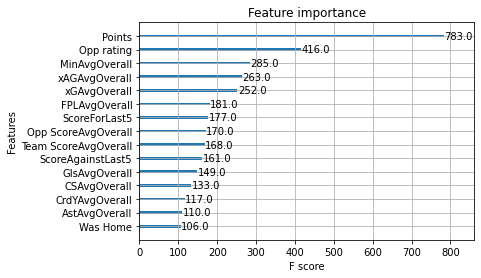

In [57]:
plot_importance(model_fwd)

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


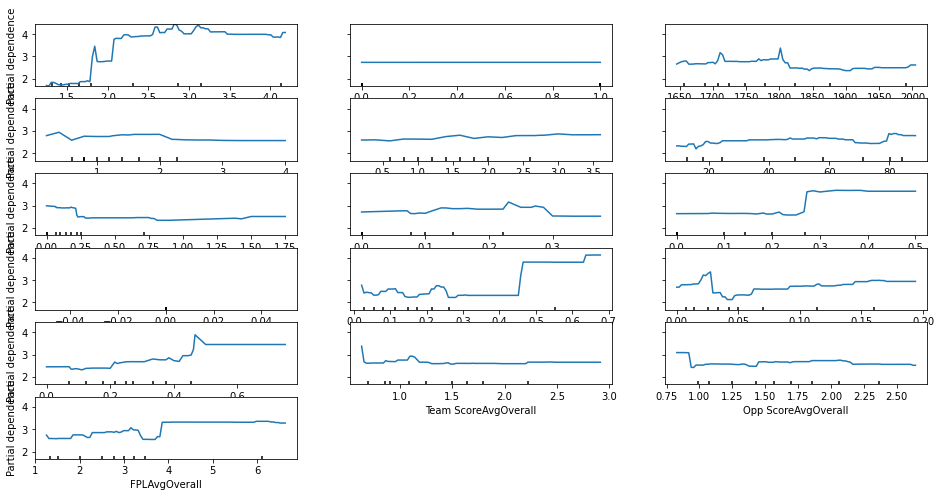

In [58]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_partial_dependence(model_fwd, X_train_fwd, features, ax=ax)

In [59]:
explainer = shap.Explainer(model_fwd, X_train_fwd)
shap_values = explainer(X_train_fwd)

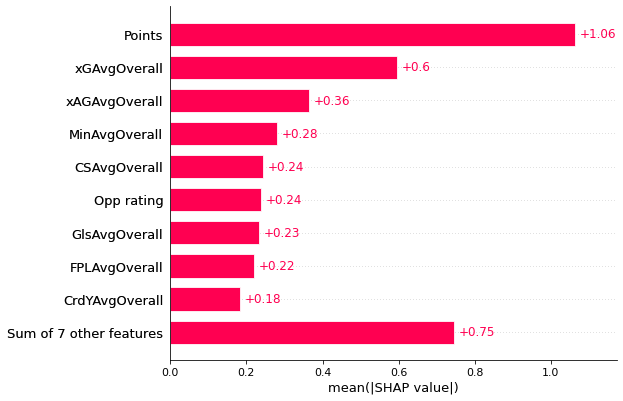

In [60]:
shap.plots.bar(shap_values)

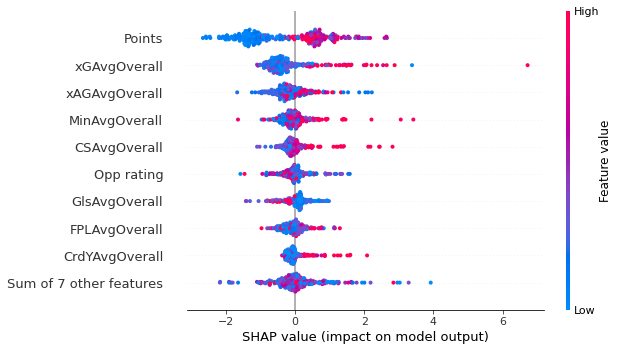

In [61]:
shap.plots.beeswarm(shap_values)

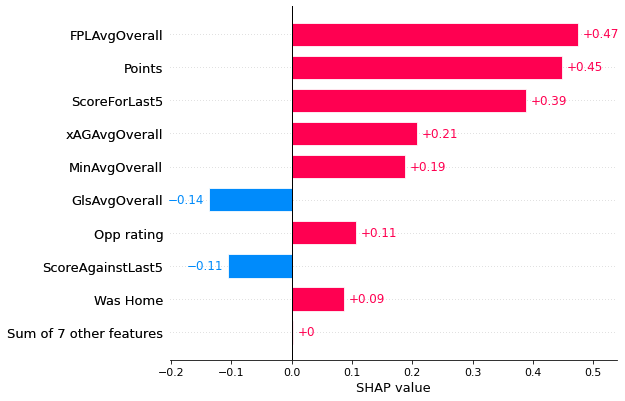

In [62]:
shap.plots.bar(shap_values[0])

In [63]:
df_predictions_fwd[["Name", "FPLAvgOverall"]]

,Name,FPLAvgOverall
10,Che-Adams,3.235294
19,Julian-Alvarez,2.600000
30,Michail-Antonio,2.375000
41,Adam-Armstrong,2.058824
79,Odsonne-Edouard,3.200000
106,Erling-Haaland,9.866667
118,Kai-Havertz,3.500000
129,Kelechi-Iheanacho,1.882353
140,Danny-Ings,3.176471
151,Brennan-Johnson,2.647059


# Saving predictions

In [64]:
df_predictions_general.to_csv("predictions/xgb/xgb_predictions_general.csv")

df_predictions_gk.to_csv("predictions/xgb/xgb_predictions_gk.csv")
df_predictions_def.to_csv("predictions/xgb/xgb_predictions_def.csv")
df_predictions_mid.to_csv("predictions/xgb/xgb_predictions_mid.csv")
df_predictions_fwd.to_csv("predictions/xgb/xgb_predictions_fwd.csv")

In [65]:
# merged predictions - mid + fwd
merged_df_predictions = pd.concat([df_predictions_mid, df_predictions_fwd])

merged_df_predictions.to_csv("predictions/xgb/xgb_predictions_merged.csv")